In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed: timeout during initial read of root folder; for more info: https://research.google.com/colaboratory/faq.html#drive-timeout

IMPORTING NECESSARY LIBRARIES

In [ ]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report , accuracy_score
import os


DATA LOADING AND PREPROCESSING

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/handwriting/english.csv')  # Path to your CSV file
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img = img.resize((28, 28))
        img_array = np.array(img)
        images.append(img_array)
    return np.array(images)


image_folder = '/content/drive/MyDrive/Colab Notebooks/handwriting/Img'  # Adjust this if the folder is named differently
images = load_images_from_folder(image_folder)

# Preprocess images
X = images.reshape(images.shape[0], -1)  # Flatten images
X = X / 255.0 # Normalize images
y = LabelBinarizer().fit_transform(data['label'] == 'S').flatten()  # Load labels and convert to binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Train-test split


BPN ALGORITHM IMPLEMENTATION

In [ ]:
# Parameters
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 1
learning_rate = 0.01
epochs = 100
batch_size = 8

# Initialize weights and biases
def initialize_params():
    W1 = np.random.randn(input_size, hidden_size1) * 0.01
    b1 = np.zeros((1, hidden_size1))
    W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
    b2 = np.zeros((1, hidden_size2))
    W3 = np.random.randn(hidden_size2, output_size) * 0.01
    b3 = np.zeros((1, output_size))
    return W1, b1, W2, b2, W3, b3

# Activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(X, W1) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    Z2 = np.dot(A1, W2) + b2
    A2 = np.maximum(0, Z2)  # ReLU activation
    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)  # Sigmoid activation
    return A3, (Z1, A1, Z2, A2, Z3)

# Backward propagation
def backward_propagation(X, y, A3, cache, W1, W2, W3):
    m = X.shape[0]
    (Z1, A1, Z2, A2, Z3) = cache

    dZ3 = A3 - y.reshape(-1, 1)
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * (Z2 > 0)  # ReLU derivative
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (Z1 > 0)  # ReLU derivative
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2, dW3, db3

# Update parameters
def update_parameters(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    return W1, b1, W2, b2, W3, b3


In [ ]:

# Model training
def train(X_train, y_train, X_test, y_test, epochs, batch_size):
    W1, b1, W2, b2, W3, b3 = initialize_params()
    weight_norms = []
    errors = []

    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            end = min(i + batch_size, X_train.shape[0])
            X_batch = X_train[i:end]
            y_batch = y_train[i:end]

            A3, cache = forward_propagation(X_batch, W1, b1, W2, b2, W3, b3)
            dW1, db1, dW2, db2, dW3, db3 = backward_propagation(X_batch, y_batch, A3, cache, W1, W2, W3)
            W1, b1, W2, b2, W3, b3 = update_parameters(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate)


        A3_test, _ = forward_propagation(X_test, W1, b1, W2, b2, W3, b3)
        error = np.mean((A3_test.flatten() - y_test) ** 2)  # Mean squared error
        errors.append(error)

        weight_norm = np.linalg.norm(np.concatenate([W1.flatten(), W2.flatten(), W3.flatten()]))
        weight_norms.append(weight_norm)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Weight norm: {weight_norm}, Error: {error}')

    return W1, b1, W2, b2, W3, b3, weight_norms, errors

W1, b1, W2, b2, W3, b3, weight_norms, errors = train(X_train, y_train, X_test, y_test, epochs, batch_size)



Epoch 0/100 - Weight norm: 3.901951262630638, Error: 0.2462706339113131
Epoch 10/100 - Weight norm: 3.902167203865337, Error: 0.2115342030095328
Epoch 20/100 - Weight norm: 3.903015177754359, Error: 0.18127965353914693
Epoch 30/100 - Weight norm: 3.9059192936218436, Error: 0.1490549083679207
Epoch 40/100 - Weight norm: 3.9181447661480604, Error: 0.08099102152015786
Epoch 50/100 - Weight norm: 3.93616951022267, Error: 0.020655623858880708
Epoch 60/100 - Weight norm: 3.9393589443942933, Error: 0.01569173802804565
Epoch 70/100 - Weight norm: 3.9403109429473395, Error: 0.015188846878846026
Epoch 80/100 - Weight norm: 3.9414035558204494, Error: 0.014930465308391334
Epoch 90/100 - Weight norm: 3.942837408432915, Error: 0.014687033060572906


ERROR CONVERGENCE AND WEIGHT CONVERGENCE PLOT

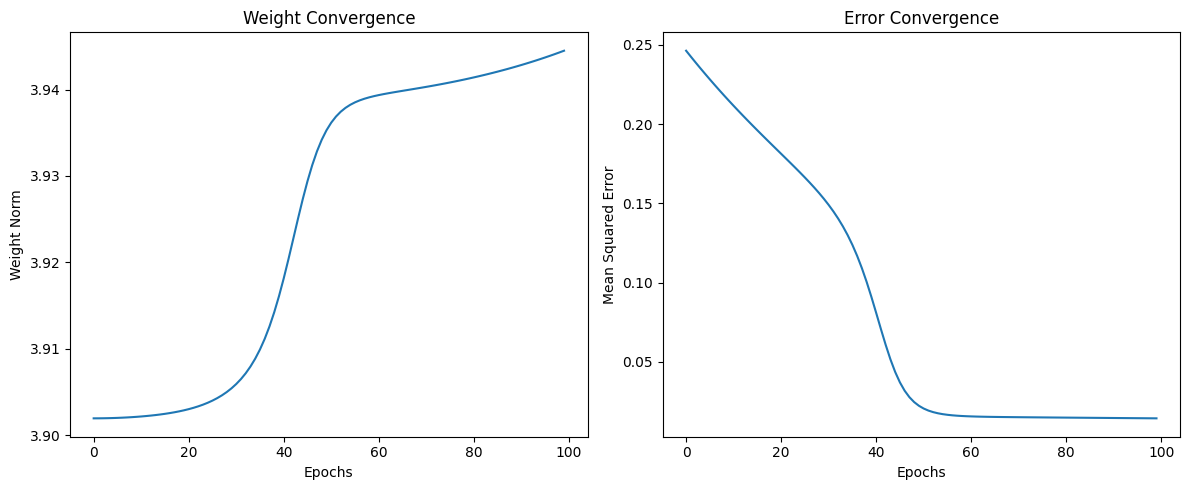

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(weight_norms)
plt.title('Weight Convergence')
plt.xlabel('Epochs')
plt.ylabel('Weight Norm')

plt.subplot(1, 2, 2)
plt.plot(errors)
plt.title('Error Convergence')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

MODEL EVALUATION

In [ ]:
def evaluate_model(X_test, y_test, W1, b1, W2, b2, W3, b3):
    A3_test, _ = forward_propagation(X_test, W1, b1, W2, b2, W3, b3)
    y_pred = (A3_test.flatten() > 0.5).astype(int)
    report = classification_report(y_test, y_pred, labels=[0, 1], target_names=['Not S', 'S'], zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    return report, accuracy


print("Classification Report on Test Data:")
report, accuracy = evaluate_model(X_test, y_test, W1, b1, W2, b2, W3, b3)
print(report)
print(f'Accuracy: {accuracy:.2f}')


Classification Report on Test Data:
              precision    recall  f1-score   support

       Not S       0.00      0.00      0.00         0
           S       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00         8
   macro avg       0.50      0.50      0.50         8
weighted avg       1.00      1.00      1.00         8

Accuracy: 1.00


PREDICTION

In [ ]:
def predict(image_path, W1, b1, W2, b2, W3, b3):
    img = Image.open(image_path)
    img = img.resize((28, 28))
    img_array = np.array(img).reshape(1, -1) / 255.0
    A3, _ = forward_propagation(img_array, W1, b1, W2, b2, W3, b3)
    return A3[0][0]

new_image_path = '/content/drive/MyDrive/Colab Notebooks/handwriting/img029-050.png'  # Adjust this to your new image path
prediction = predict(new_image_path, W1, b1, W2, b2, W3, b3)
print(f'Prediction for the new image: {"S" if prediction > 0.5 else "Not S"}')

Prediction for the new image: S
